In [61]:
import pandas as pd 
import requests 
import numpy as np
from scipy.stats import norm
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

# A/B
Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [62]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-madenov/x/proekt.csv', sep=';')

In [63]:
# Для удобства переименуем названия групп [a, b] в [control, test]
df.testgroup = df.testgroup.replace(to_replace=['b', 'a'], value=['test', 'control'])

In [64]:
# Смотрю на размер тестовой и контрольной группы
df.testgroup.value_counts()

test       202667
control    202103
Name: testgroup, dtype: int64

In [65]:
# Процентное содержание в каждой группе
df.testgroup.value_counts(normalize=True)

test       0.500697
control    0.499303
Name: testgroup, dtype: float64

In [66]:
# Количество уникальных пользователей
df.user_id.nunique()

404770

In [67]:
# Размер группы
group_size = df.groupby('testgroup', as_index=False).agg({'revenue': 'count'}) \
    .rename(columns={'revenue': 'group_size'})

In [68]:
# Размер группы которая совершала покупку
pay_group_size = df.query('revenue > 0').groupby('testgroup', as_index=False).agg({'revenue': 'count'}) \
    .rename(columns={'revenue': 'pay_group_size'})

In [69]:
KPI = group_size.merge(pay_group_size, on='testgroup')

In [70]:
# Конверсия в покупку
KPI['CR']= KPI.pay_group_size / KPI.group_size

In [71]:
# Выручка
revenue = df.groupby('testgroup', as_index=False).agg({'revenue': 'sum'})

In [72]:
# Мерджим выручку к KPI
KPI = KPI.merge(revenue, on='testgroup')

In [73]:
# Средний доход на платящего пользователя
KPI['ARPPU'] = KPI.revenue / KPI.pay_group_size

In [74]:
# Средний доход на пользователя
KPI['ARPU'] = KPI.CR * KPI.ARPPU

In [75]:
# Вывожу ключевые показатели эффективности для тестов
KPI

,testgroup,group_size,pay_group_size,CR,revenue,ARPPU,ARPU
0,control,202103,1928,0.009540,5136189,2663.998444,25.413720
1,test,202667,1805,0.008906,5421603,3003.658172,26.751287


# Выводы по основным показателям:
    Если считать что выборки в контрольной и тестовой группе равны и все пользователи уникальны(т.е нету людей которые совершали повторные покупки), то тестовая группа показывает себя лучше, т.к выручка и средний доход с пользователя увеличились на 5%, а средний доход с платящего пользователя увечилися на 13%. Но конверсия в покупателя в контрольной группе на 7% больше. Для дальнейшего анализа необходимо посмотреть как распределяются значения в наших группах и провести тест, что бы понять не случайным ли образом у нас получились такие различия в группах.

# Тестовая группа

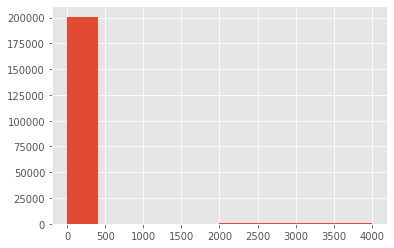

In [76]:
# Распределение для тестовой группы
df.query('testgroup == "test"').revenue.hist()

In [77]:
# Смотрю максимальный чек в тестовой группе 
df.query('testgroup == "test" & revenue > 1000').revenue.max()

4000

In [78]:
# Смотрю минимальный чек в тестовой группе
df.query('testgroup == "test" & revenue > 1000').revenue.min()

2000

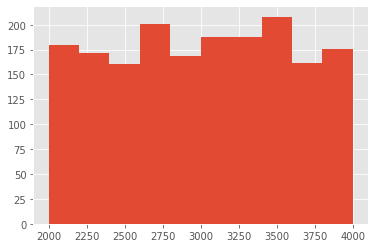

In [79]:
# Распределение для пользователей из тестовой которые совершали покупки
df.query('testgroup == "test" & revenue>1000').revenue.hist()

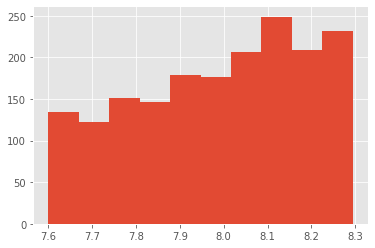

In [80]:
# Логарифмирую чтобы посмотреть не получится ли нормальное распределение
np.log(df.query('testgroup == "test" & 1500<revenue<5000').revenue).hist()

# Контрольная группа

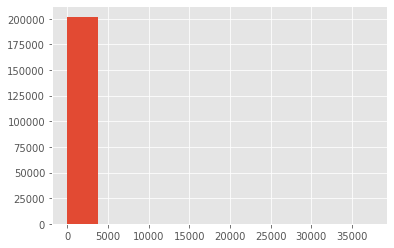

In [81]:
# Распределение для контрольной группы
df.query('testgroup == "control"').revenue.hist()

In [82]:
# Смотрю максимальный чек в контрольной группе 
df.query('testgroup == "control" & revenue > 1000').revenue.max()

37433

In [83]:
# Смотрю минимальный чек в контрольной группе при чеке больше 1000
df.query('testgroup == "control" & revenue > 1000').revenue.min()

37293

In [84]:
# Количество пользователей которые совершили крупную покупку от 37293 до 37433
df.query('testgroup == "control" & revenue > 1000').revenue.count()

123

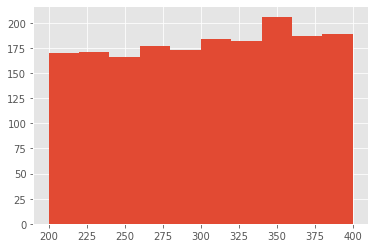

In [85]:
# Распределение для пользователей из контрольной группы которые совершали покупки от 0 до 500
df.query('testgroup == "control" & 0<revenue<5000').revenue.hist()

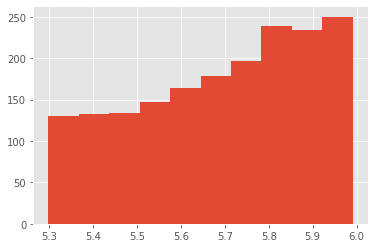

In [86]:
# Логарифмирую чтобы посмотреть не получится ли нормальное распределение
np.log(df.query('testgroup == "control" & 0<revenue<5000').revenue).hist()

# Выводы по распределениям
    В тестовой и контрольных группах мы видим большое количество пользователей которые не совершали покупки, из-за этого наше распределение сильно скошено в левую сторону. После избавление от таких пользователей мы наблюдаем:
    
    1)В тестовой группе пользователи в количестве 1805 человек совершали покупки от 2000 до 4000
    2)В контрольной группе основная масса пользователей совершала покупки от 200 до 400, а так же появился явный хвост с пользователями в количестве 123, которые совершали крупные покупки от 37293 до 37433. Для более детальной оценки что это за пользователи и не баг ли это, необходимо больше информации о данных.
    
    Распределения в наших группах не нормальное, а следовательно и распределение средних не нормальное, что не дает нам возпользоваться Т-тестом для проверки различия наших выборок. Но мы можем воспользоваться бутстрепом, установив порог уровня значимости в 5%.
    

# Провожу бутстреп для проверки среднего чека

In [87]:
df

,user_id,revenue,testgroup
0,1,0,test
1,2,0,control
2,3,0,control
3,4,0,test
4,5,0,test
...,...,...,...
404765,404766,0,control
404766,404767,0,test
404767,404768,231,control
404768,404769,0,control


In [88]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95,  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, replace=True  # параметр возвращения
        ).values

        samples_2 = data_column_2.sample(
            boot_len,  # чтобы сохранить дисперсию, берем такой же размер выборки
            replace=True,
        ).values

        boot_data.append(statistic(samples_1 - samples_2))
    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    p_2 = norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
    p_value = min(p_1, p_2) * 2

    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if (
            abs(bar.get_x()) <= quants.iloc[0][0]
            or abs(bar.get_x()) >= quants.iloc[1][0]
        ):
            bar.set_facecolor("red")
        else:
            bar.set_facecolor("grey")
            bar.set_edgecolor("black")

    plt.style.use("ggplot")
    plt.vlines(quants, ymin=0, ymax=50, linestyle="--")
    plt.xlabel("boot_data")
    plt.ylabel("frequency")
    plt.title("Histogram of boot_data")
    plt.show()

    return {"boot_data": boot_data, "quants": quants, "p_value": p_value}

In [89]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

In [90]:
n = 1000

sample_1 = np.random.exponential(scale=1 / 0.001, size=n)
sample_2 = np.random.exponential(scale=1 / 0.00101, size=n)

df1 = pd.DataFrame({"sample_1": sample_1, "sample_2": sample_2})

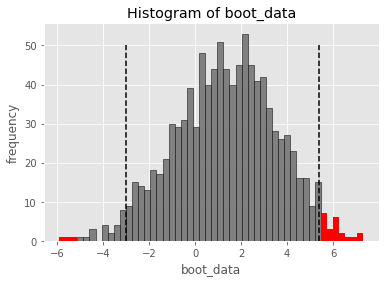

{'boot_data': [-4.036379874375206,
  2.7518786975679315,
  -2.22222167397751,
  2.3758678028490086,
  1.1656658459443323,
  1.9548273769286564,
  2.740544834630206,
  1.8143851737085959,
  0.81162695456093,
  -1.7595069744951077,
  3.069315675467639,
  2.130593535208001,
  1.1596214479910394,
  -0.4445667030152911,
  2.2045670977514837,
  2.9246695317935334,
  0.33278234739745494,
  0.8259657467668639,
  1.54268825215748,
  3.706271864684433,
  0.18655725895187672,
  0.8061055820631874,
  3.7575234251259455,
  1.5860549571464522,
  2.8608801630260476,
  0.9840526578081286,
  0.39760296446880844,
  3.214465107787652,
  2.9818914771521756,
  0.07727454395634217,
  3.491555112573828,
  1.1664158447107817,
  3.0586479298553786,
  4.192058894639976,
  2.874044615058199,
  3.4776258591679947,
  -0.2818021680885393,
  4.292168927353738,
  2.5474645600911843,
  3.216458525561636,
  -3.128980051019653,
  2.2668219295691947,
  6.219058850232154,
  -0.510270542318187,
  0.6059545954694153,
  3.02

In [91]:
# Провожу бусттрап для средней статистики
get_bootstrap(
    df[df.testgroup == "test"].revenue,  # числовые значения первой выборки
    df[df.testgroup == "control"].revenue,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95,  # уровень значимости
)

# Выводы:
    Бутстрап на средних значениях показывает значение уровня значимости больше 5%, следовательно мы не можем отклонить нулевую гиппотезу.
    Теперь необходимо проверить стат.значимо ли отличается конверсия в наших группах, для этого мы создадим колонку с категориальной переменной(пользователи которые совершали покупки и не совершали) и воспользуемся критерием Хи-квадрат

In [97]:
df['pay_user'] = df.revenue > 0 

In [95]:
chi2_contingency(pd.crosstab(df.pay_user, df.testgroup))

(4.374729521260405,
 0.03647561892312613,
 1,
 array([[200239.10075104, 200797.89924896],
        [  1863.89924896,   1869.10075104]]))

# Выводы : 
    На данном этапе не стоит ставить в ход вариант предложенный для тестовой группы, т.к ARPU в группах показали не стат.значимые различия, а вот конверсия в покупку стат.значимо уменьшилась. Но, если рассматривать исключитель платежспособный сегмент мы видим достаточно серьезную разницу в чеках, которые они совершали. Вариант с тестовой группой показал себя более стабильно, и возможно если если увеличить конверсию и показать дорогостоящие акционные предложения из контрольного варианта можно добиться увеличения прибыли.